In [1]:
import os
import numpy as np
import pandas as pd
import scipy.stats as st
import arviz as az
import sys
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
pd.options.mode.chained_assignment = None  # default='warn'

from helper_functions import *

# Simulated data

In [2]:
root_dir = os.getcwd()

data_dir = "/computational_model_data/"

target_string = "output"

runs = []

for subdir, dirs, files in os.walk(root_dir+data_dir):
    for file in files:
        if target_string in file:
            runs.append(file)

In [3]:
simulated_data = pd.DataFrame()

for file_name in runs:
    temp = file_name.split("_")
    code = temp[4]
    level = temp[5]

    temp_data = pd.read_csv(f"{root_dir}/computational_model_data/{file_name}", index_col=False)
    temp_data['convolution_granularity'] = code
    temp_data['level'] = level

    simulated_data = pd.concat([simulated_data, temp_data])

In [4]:
simulated_action_goals = simulated_data[simulated_data.action_goal_selected == True]

In [5]:
spaceship_center_x=658 + 14
spaceship_center_y=288 + 14

# annotate distance to spaceship
simulated_action_goals["distance_to_spaceship_in_pixel"] = np.sqrt(
    np.power((simulated_action_goals.action_goal_x - spaceship_center_x), 2) +
    np.power((simulated_action_goals.action_goal_y - spaceship_center_y), 2))
simulated_action_goals["distance_to_spaceship"] = simulated_action_goals['distance_to_spaceship_in_pixel'].apply(lambda x: pixel_to_degree(x))
simulated_action_goals["distance_to_spaceship_log"] = np.log(simulated_action_goals.distance_to_spaceship)


## Experimental data

In [6]:
fix_data = pd.read_csv('eye_data/experimental_eye_data_fixations.csv', index_col=False)
distant_fixations = fix_data[fix_data.exploring_fixation == 1]
DistFix_no_drift = distant_fixations[distant_fixations.N_visible_drift_tiles == 0]
DistFix_no_drift['distance_to_spaceship_log'] = np.log(DistFix_no_drift.distance_to_spaceship)

# Plotting

In [7]:
# game features:
scaling=18
edge=34
observation_space_x=40
observation_space_y=60
bottom_edge=15

In [8]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

/var/folders/z1/crk0j_p52yq850yynjpq93wm0000gn/T/ipykernel_3473/2622629050.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  target_fixations = exp_dat[DistFix_no_drift["converging_eye_x_adjusted"].between(x_bounds[0], x_bounds[1])]
/var/folders/z1/crk0j_p52yq850yynjpq93wm0000gn/T/ipykernel_3473/2622629050.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  target_fixations = exp_dat[DistFix_no_drift["converging_eye_x_adjusted"].between(x_bounds[0], x_bounds[1])]
/var/folders/z1/crk0j_p52yq850yynjpq93wm0000gn/T/ipykernel_3473/2622629050.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  target_fixations = exp_dat[DistFix_no_drift["converging_eye_x_adjusted"].between(x_bounds[0], x_bounds[1])]
/var/folders/z1/crk0j_p52yq850yynjpq93wm0000gn/T/ipykernel_3473/2622629050.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  target_fixations = exp_dat[DistFix_n

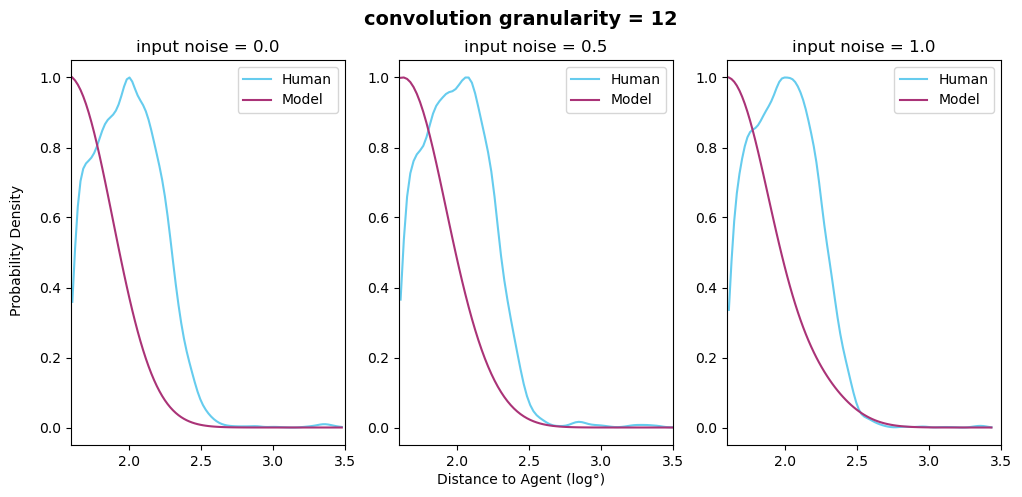

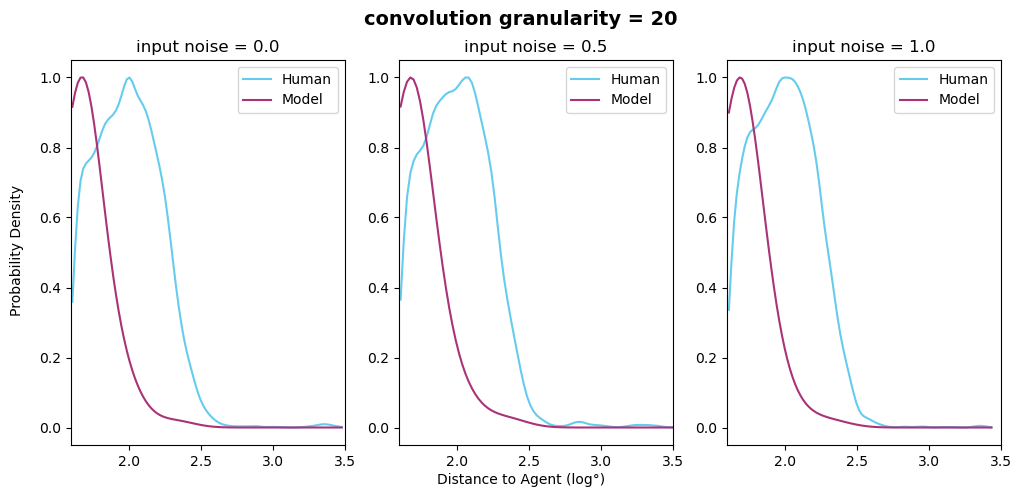

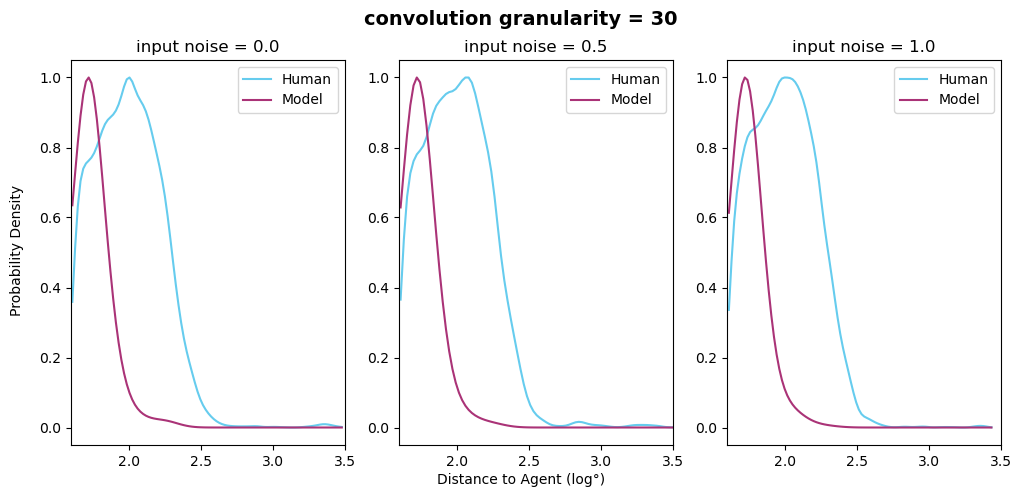

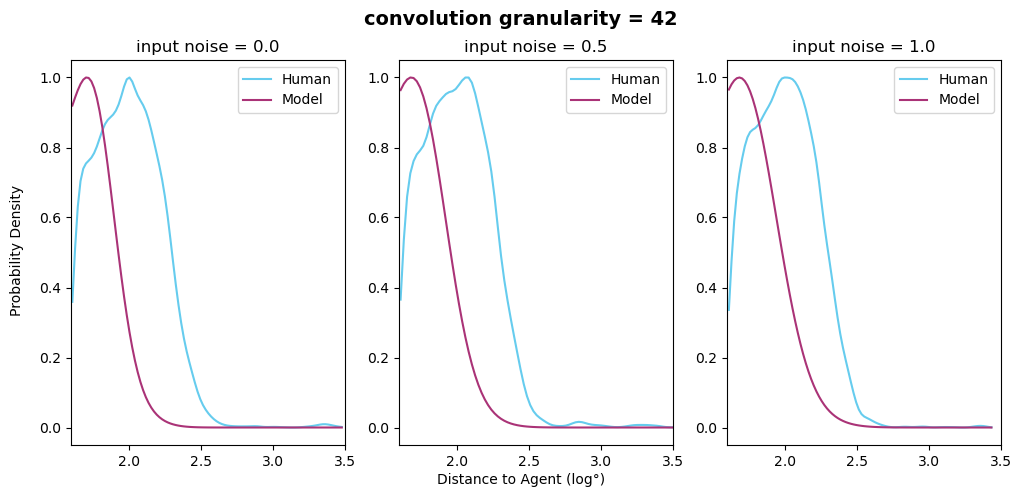

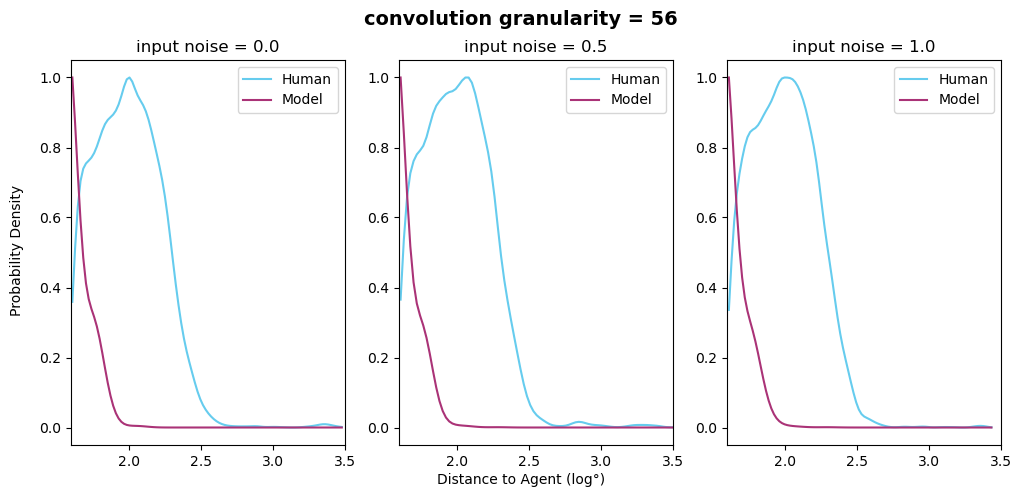

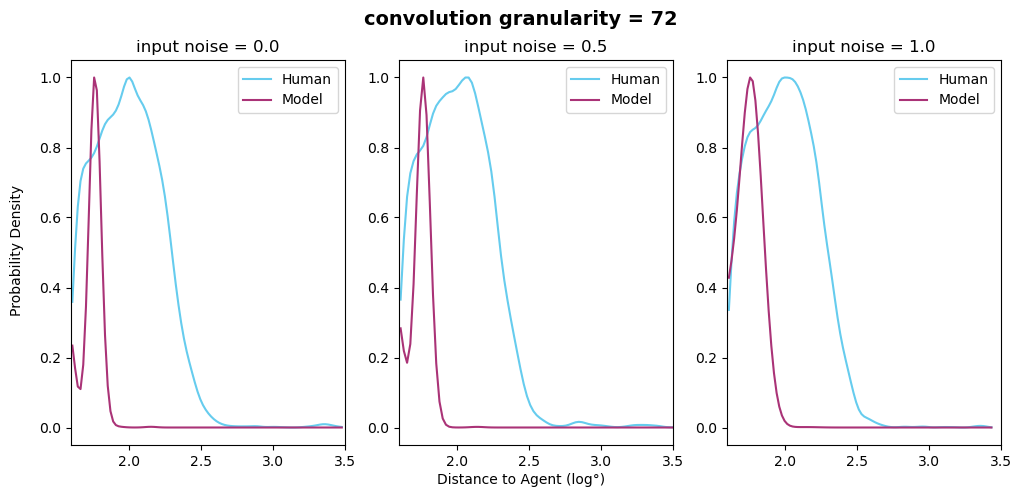

In [9]:

for convolution_granularity in ['12', '20', '30', '42', '56', '72']:
    
    fig, ax = plt.subplots(1, 3, figsize=(12, 5))
    fig.suptitle(f'convolution granularity = {convolution_granularity}', weight="bold", fontsize=14)
    
    # axis labels    
    fig.text(0.5, 0.04, 'Distance to Agent (log°)', ha='center', va='center')
    fig.text(0.08, 0.5, 'Probability Density', ha='center', va='center', rotation='vertical')
    
    for input_noise, input_noise_magnitude, subplot_pos in zip(['N', 'W', 'S'], [0.0, 0.5, 1.0], [0, 1, 2]):
        
        exp_dat = DistFix_no_drift[DistFix_no_drift.input_noise == input_noise]
        sim_dat = simulated_action_goals[(simulated_action_goals.convolution_granularity == convolution_granularity) & (simulated_action_goals.input_noise_magnitude == input_noise_magnitude)]

        # initiate plot 
        ax[subplot_pos].set_title(f"input noise = {input_noise_magnitude}", fontsize=12)

        x_bounds = [edge*scaling, (edge+observation_space_x)*scaling]
        y_bounds = [0, (observation_space_y - bottom_edge)*scaling]

        ax[subplot_pos].set_xlim([1.6, 3.5])

        # check for fixation within game boarders
        target_fixations = exp_dat[DistFix_no_drift["converging_eye_x_adjusted"].between(x_bounds[0], x_bounds[1])]
        
        # sampling
        kde_human = st.gaussian_kde(np.asarray(target_fixations.distance_to_spaceship_log))
        kde_model = st.gaussian_kde(np.asarray(sim_dat.distance_to_spaceship_log))
        
        dist_space = np.linspace(min(target_fixations.distance_to_spaceship_log), max(target_fixations.distance_to_spaceship_log), 100 )

        prob_dens_human = NormalizeData(kde_human(dist_space))
        prob_dens_model = NormalizeData(kde_model(dist_space))

        ax[subplot_pos].plot( dist_space, prob_dens_human, label="Human", color='#66CCEE')
        ax[subplot_pos].plot( dist_space, prob_dens_model, label="Model", color='#AA3377')
        
        ax[subplot_pos].legend()


# Likelihood profile

In [10]:
# works for multiple metrics:

def calc_likelihood(s_star, s, single_stat=False, debugme="nope"):
    # calculates a single likelihood from data statistics s
    # and model replicate statistics s_star

    s = np.matrix(s).transpose()
    if debugme == "debug":
        print("s")
        print(s)
    
    # if only a single metric is used to calculate the likelihood, do not apply .transpose()
    if single_stat:
        s_star = np.matrix(s_star)
    else:
        s_star = np.matrix(s_star).transpose()
    if debugme == "debug":
        print("s_star")
        print(s_star)

    mu_hat = np.mean(s_star, axis=1)  # axis = 1 for ->
    if debugme == "debug":
        print("mu_hat")
        print(mu_hat)

    S = s_star - mu_hat
    if debugme == "debug":
        print("S")
        print(S)

    Sigma_hat = np.dot(S, np.transpose(S)) / (np.shape(S)[1] - 1)
    if debugme == "debug":
        print("Sigma_hat")
        print(Sigma_hat)

    tmp1 = np.transpose(-1 / 2 * (s - mu_hat))
    if debugme == "debug":
        print("tmp1")
        print(tmp1)

    if np.linalg.cond(Sigma_hat) < (1 / sys.float_info.epsilon):
        tmp2 = np.linalg.inv(Sigma_hat)
    else:
        tmp2 = np.linalg.pinv(Sigma_hat)
    tmp2 = np.linalg.inv(Sigma_hat)
    if debugme == "debug":
        print("tmp2")
        print(tmp2)

    tmp3 = (s - mu_hat)
    if debugme == "debug":
        print("tmp3")
        print(tmp3)

    tmp4 = -1 / 2 * np.log(np.linalg.norm(Sigma_hat))
    if debugme == "debug":
        print("tmp4")
        print(tmp4)

    l_s = np.dot(np.dot(tmp1, tmp2), tmp3) + tmp4

    if debugme == "debug":
        print("l_s")
        print(l_s)
        print("\n\n")

    return float(l_s)

In [11]:
s = np.asarray(DistFix_no_drift.groupby(['input_noise'])['distance_to_spaceship_log'].mean())
s

array([2.23096436, 2.24759685, 2.22265954])

In [13]:
y_star = simulated_action_goals[simulated_action_goals.convolution_granularity == '56']
#(y_star.groupby(['level', 'input_noise_magnitude'])['distance_to_spaceship_log'].mean()).to_list()
s_stats = (y_star.groupby(['input_noise_magnitude', 'level'])['distance_to_spaceship_log'].mean()).to_list()
s_star = np.array_split(np.array(s_stats),3)
s_star

[array([1.4940629 , 1.49279957, 1.50576384, 1.48787134, 1.46521528,
        1.49558663]),
 array([1.52613121, 1.50657864, 1.49972279, 1.50359959, 1.48559909,
        1.4214952 ]),
 array([1.52076617, 1.51523849, 1.48996679, 1.48316363, 1.47926927,
        1.41826701])]

In [14]:
calc_likelihood(s_star, s, single_stat=True, debugme='debug')

s
[[2.23096436]
 [2.24759685]
 [2.22265954]]
s_star
[[1.4940629  1.49279957 1.50576384 1.48787134 1.46521528 1.49558663]
 [1.52613121 1.50657864 1.49972279 1.50359959 1.48559909 1.4214952 ]
 [1.52076617 1.51523849 1.48996679 1.48316363 1.47926927 1.41826701]]
mu_hat
[[1.49021659]
 [1.49052109]
 [1.48444522]]
S
[[ 0.00384631  0.00258298  0.01554724 -0.00234525 -0.02500131  0.00537003]
 [ 0.03561013  0.01605756  0.0092017   0.0130785  -0.004922   -0.06902589]
 [ 0.03632094  0.03079326  0.00552156 -0.0012816  -0.00517596 -0.06617822]]
Sigma_hat
[[1.84517117e-04 8.64352293e-06 1.64234135e-05]
 [8.64352293e-06 1.31408878e-03 1.28307813e-03]
 [1.64234135e-05 1.28307813e-03 1.34118266e-03]]
tmp1
[[-0.37037389 -0.37853788 -0.36910716]]
tmp2
[[  5442.50080071    444.23275913   -491.63309103]
 [   444.23275913  11583.88298332 -11087.47013202]
 [  -491.63309103 -11087.47013202  11358.75458434]]
tmp3
[[0.74074777]
 [0.75707576]
 [0.73821431]]
tmp4
2.9727091245328343
l_s
[[-1688.63858266]]





-1688.6385826621697

In [15]:
s = np.asarray(DistFix_no_drift.groupby(['input_noise'])['distance_to_spaceship_log'].mean())

for convolution_granularity in ['20', '30', '42', '56', '72']:
    
    y_star = simulated_action_goals[simulated_action_goals.convolution_granularity == convolution_granularity]
    s_stats = (y_star.groupby(['input_noise_magnitude', 'level'])['distance_to_spaceship_log'].mean()).to_list()
    s_star = np.array_split(np.array(s_stats),3)

    print(calc_likelihood(s_star, s, single_stat=True, debugme='no'))

-1287.230045530833
-1416.8876042284319
-121.14041255213507
-1688.6385826621697
-788.8164194572759
